# **マイドライブへのアクセス**

In [1]:
# マイドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/'My Drive'/研究

/content/drive/My Drive/研究


# **ライブラリのインストール**


In [3]:
# 必要なライブラリを準備
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

# **データセットの準備**

In [4]:
import pandas as pd
import glob
import MeCab

# マイドライブのデータセットの読み込み
csv_files = glob.glob("ver-20200312/*.csv")

columns = ['dialogue', 'MITI_code', 'target']
datasets = pd.DataFrame(index=[], columns=columns)

for csv_file in csv_files:
  # データの読込
  records = pd.read_csv(csv_file, sep=',', encoding='cp932')

  # 余分な空白を削除
  records["dialogue"] = records["dialogue"].str.strip()

  # データのtargetを一律に修正
  records.fillna(records.iat[0, 3], inplace=True)

  # 面接者のみの発話を抽出
  records = records.loc[records['NO'].str.contains('Co'), ["dialogue", "MITI_code", "target"]]

  # 全csvファイルを1つのpandasに結合
  datasets = pd.concat([datasets, records], ignore_index=True)

# ラベル6を除外
datasets = datasets[datasets["MITI_code"] != 6]

# 単語ごとに分割
tagger = MeCab.Tagger('-Owakati')
datasets["dialogue"] = [tagger.parse(sentence).strip() for sentence in datasets["dialogue"]]

# ラベルをstr型に変換
datasets["MITI_code"] = [str(sentence) for sentence in datasets["MITI_code"]]

print(datasets)

                                              dialogue MITI_code        target
0    現状 について お話し いただき ありがとう ござい まし た 。 そんな 中 、 こちら ...         3  転職に向けた行動を起こす
1    やる気 を 高め て 転職 活動 を 行い 、 来年度 から は 新しい 職場 で 働き た...         2  転職に向けた行動を起こす
2                   早急 に 脱出 し たい という 思い が 強い わけ です ね 。         2  転職に向けた行動を起こす
3    それでも なかなか やる気 が 出 て こ ない という の は 、 何 度 か 失敗 し ...         2  転職に向けた行動を起こす
4         ただ 、 ご 自身 として は 、 そう も 言っ て い られ ない 状況 だ と 。         2  転職に向けた行動を起こす
..                                                 ...       ...           ...
183  OK ， 他 の 方 と 一緒 に 体験 する こと が できる サポート グループ や 勉...         0            禁煙
184  もちろん ， 時間 も たくさん 取ら れる かも しれ ませ ん し ， あなた の 生活...         4            禁煙
185  OK ， では もし よけれ ば ， あなた が 来ら れる とき に 一度 予約 を 取り...         0            禁煙
186                                            よかっ た 。         0            禁煙
187                                               はい 。         0            禁煙

[187 rows x 3 columns]


# **学習と予測**

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Leave-One-Outのインスタンス生成
loo = LeaveOneOut()

# pandasをnumpyに変換
x = datasets["dialogue"].values
y = datasets["MITI_code"].values

# 予測結果のリスト
predict_list = np.empty(0)

# Leave-One-Out手法で学習・予測
for train_index, test_index in loo.split(x):

  # 訓練データとテストデータを分割
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

  # tf-idfを基にベクトル化
  tfidf = TfidfVectorizer(ngram_range=(1, 1))  # ngram_rangeでTF-IDFを計算する単語の長さを指定
  x_train = tfidf.fit_transform(x_train)  # 訓練データの単語のみtf-idfで利用
  x_test = tfidf.transform(x_test)

  # ベクトルをpandasに変換
  x_train = pd.DataFrame(x_train.toarray(), columns=tfidf.get_feature_names())
  x_test = pd.DataFrame(x_test.toarray(), columns=tfidf.get_feature_names())

  # モデルの学習
  model = LogisticRegression(random_state=46, max_iter=1000, C=10)
  model.fit(x_train, y_train)

  # モデルの予測
  predict = model.predict(x_test)
  predict_list = np.append(predict_list, predict)
  print("テストデータのindex：" + str(test_index[0]))

  # インスタンスの初期化
  del model
  del tfidf

# 正答率の計算
accuracy = accuracy_score(y, predict_list)
print(f'正解率（評価データ）：{accuracy:.3f}')

テストデータのindex：0
テストデータのindex：1
テストデータのindex：2
テストデータのindex：3
テストデータのindex：4
テストデータのindex：5
テストデータのindex：6
テストデータのindex：7
テストデータのindex：8
テストデータのindex：9
テストデータのindex：10
テストデータのindex：11
テストデータのindex：12
テストデータのindex：13
テストデータのindex：14
テストデータのindex：15
テストデータのindex：16
テストデータのindex：17
テストデータのindex：18
テストデータのindex：19
テストデータのindex：20
テストデータのindex：21
テストデータのindex：22
テストデータのindex：23
テストデータのindex：24
テストデータのindex：25
テストデータのindex：26
テストデータのindex：27
テストデータのindex：28
テストデータのindex：29
テストデータのindex：30
テストデータのindex：31
テストデータのindex：32
テストデータのindex：33
テストデータのindex：34
テストデータのindex：35
テストデータのindex：36
テストデータのindex：37
テストデータのindex：38
テストデータのindex：39
テストデータのindex：40
テストデータのindex：41
テストデータのindex：42
テストデータのindex：43
テストデータのindex：44
テストデータのindex：45
テストデータのindex：46
テストデータのindex：47
テストデータのindex：48
テストデータのindex：49
テストデータのindex：50
テストデータのindex：51
テストデータのindex：52
テストデータのindex：53
テストデータのindex：54
テストデータのindex：55
テストデータのindex：56
テストデータのindex：57
テストデータのindex：58
テストデータのindex：59
テストデータのindex：60
テストデータのindex：61
テストデータのindex：62
テス

# **混同行列の作成**

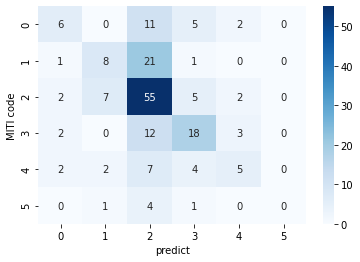

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 混合行列の作成
test_cm = confusion_matrix(y, predict_list)
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.xlabel('predict')
plt.ylabel('MITI code')
plt.show()

# **重みが高い上位10単語**

In [17]:
#訓練データのtf-idfの単語群
features = x_train.columns.values

#ラベル名一覧
label_names = ["どれにも該当しない", "単純な聞き返し", "複雑な聞き返し", "開かれた質問", "閉じた質問", "是認"]

best10_index = [i for i in range(1, 11)]

# 重みが高い上位10単語を表示
for c, coef in zip(model.classes_, model.coef_): 
  print(f'【MITIコード】{c}：{label_names[int(c)]}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=best10_index).T
  display(best10)
  print('\n')

【MITIコード】0：どれにも該当しない


,1,2,3,4,5,6,7,8,9,10
重要度上位,はい,うん,よかっ,まし,それでは,つもり,あなた,非常,言い訳,だけ




【MITIコード】1：単純な聞き返し


,1,2,3,4,5,6,7,8,9,10
重要度上位,自分,お金,毎月,勉強,体重,とる,美味しかっ,乗り切れれ,って,たく




【MITIコード】2：複雑な聞き返し


,1,2,3,4,5,6,7,8,9,10
重要度上位,ない,ちょっと,そういう,感じる,30,恐ろしい,しまう,あっ,限り,会社




【MITIコード】3：開かれた質問


,1,2,3,4,5,6,7,8,9,10
重要度上位,どんな,どう,です,どうして,困り,役に立っ,でし,について,どういう,今日




【MITIコード】4：閉じた質問


,1,2,3,4,5,6,7,8,9,10
重要度上位,10,それで,ます,として,もらい,お尋ね,よろしい,なけれ,られ,考え




【MITIコード】5：是認


,1,2,3,4,5,6,7,8,9,10
重要度上位,なかっ,それ,くれ,意識,うしろめた,過去,来よ,将来,ちなん,見据え
